 ![CellphoneDB Logo](https://www.cellphonedb.org/images/cellphonedb_logo_33.png) | CellphoneDB is a publicly available repository of curated receptors, ligands and their interactions.

# CellphoneDB method 2 (statistical analysis)
In this example we are using the method 2 (`statistical_analysis_method`) to study how cell-cell interactions change between a subset of immune cells and trophoblast cells as the trophoblast differentiate and invade the maternal uterus. This method will retrieve interactions where the mean expression of the interacting partners (proteins participating in the interaction) displays significant cell state specificity by employing a random shuffling methodology. 

This notebook assumes that you either know how two **download CellphoneDB database or to create your own database**. If this is not the case, please check `T0_BuildDBfromFiles.ipynb` or `T0_BuildDBfromRelease.ipynb`. In this notebook we will explain how to run CellphoneDB for the **statistical method**.

### Check python version

In [1]:
import pandas as pd
import sys
import os

pd.set_option('display.max_columns', 100)
# Define our base directory for the analysis
os.chdir('/home/jovyan/cpdb_tutorial')

Checking that environment contains a Python >= 3.8 as required by CellphoneDB.

In [2]:
print(sys.version)

3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:20:04) [GCC 11.3.0]


### Install CellphoneDB

Installing last version of CellphoneDB in the current conda enviroment. \
Remove the `--quiet` flag in case you want to see a detailed description of the installation process.

> pip install --quiet cellphonedb

___
### Input files
The statistial method accepts 5 input files (3 mandatory).
- **cpdb_file_path**: (mandatory) path to the database `cellphonedb.zip`.
- **meta_file_path**: (mandatory) path to the meta file linking cell barcodes to cluster labels `metadata.tsv`.
- **counts_file_path**: (mandatory) paths to normalized counts file (not z-transformed), either in text format or h5ad (recommended) `normalised_log_counts.h5ad`.
- **microenvs_file_path** (optional) path to microenvironment file that groups cell clusters by microenvironments. When providing a microenvironment file, CellphoneDB will restrict the interactions to those cells within a microenvironment.
- **active_tf_path**: (optional) to the active transcription factors.

The `microenvs_file_path` content will depend on the biological question that the researcher wants to answer.

> In this **example** we are studying how cell-cell interactions change between a subset of immune cells and trophoblast cells as the trophoblast differentiate and invade the maternal uterus. This module will randomly permute the cluster labels of all cells whitin each microenvironement (`microenvs_file_path`), 1,000 times (default), to test whether the mean average receptor expression level in a cluster and the average ligand expression level between the interacting clusters is higher than those of the rest cell pairs. This procedure generates a P-value for the likelihood of cell-type specificity of a given receptor–ligand complex.

In [3]:
cpdb_file_path = 'db/v5/cellphonedb.zip'
meta_file_path = 'data/metadata.tsv'
counts_file_path = 'data/normalised_log_counts.h5ad'
microenvs_file_path = 'data/microenvironment.tsv'
active_tf_path = 'data/active_TFs.tsv'
out_path = 'results/method2_withScore'

### Inspect input files

<span style="color:green">**1)**</span> The **metadata** file is compossed of two columns:
- **barcode_sample**: this column indicates the barcode of each cell in the experiment.
- **cell_type**: this column denotes the cell label assigned.

In [4]:
metadata = pd.read_csv(meta_file_path, sep = '\t')
metadata.head(3)

,barcode_sample,cell_type
0,AGCGATTAGTCTAACC-1_Pla_HDBR10917733,B_cells
1,ATCCGTGAGGCTAGAA-1_Pla_Camb10714918,B_cells
2,AGTAACCCATTAAAGG-1_Pla_HDBR10917733,B_cells


<span style="color:green">**2)**</span>  The **counts** files is a scanpy h5ad object. The dimensions and order of this object must coincide with the dimensions of the metadata file (i.e. must have the same number of cells in both files).

In [5]:
import anndata

adata = anndata.read_h5ad(counts_file_path)
adata.shape

(3312, 30800)

Check barcodes in metadata and counts are the same.

In [6]:
list(adata.obs.index).sort() == list(metadata['barcode_sample']).sort()

True

<span style="color:green">**3)**</span> **Micronevironments** defines the cell types that belong to a a given microenvironemnt. CellphoneDB will only calculate interactions between cells that belong to a given microenvironment. In this file we are defining two microenvionments.

In [7]:
microenv = pd.read_csv(microenvs_file_path,
                       sep = '\t')
microenv.head(3)

,cell_type,microenvironment
0,PV MMP11,Env1
1,PV MYH11,Env1
2,PV STEAP4,Env1


Displaying cells grouped per microenvironment

In [8]:
microenv.groupby('microenvironment', group_keys = False)['cell_type'].apply(lambda x : list(x.value_counts().index))

microenvironment
Env1    [PV MMP11, PV MYH11, PV STEAP4, EVT_1, EVT_2, ...
Name: cell_type, dtype: object

<span style="color:green">**4)**</span> **Active transcription factors** defines trancription factors active in a given cell type.

In [9]:
pd.read_csv(active_tf_path, sep = '\t') \
    .head(3)

,cell_type,TF
0,EVT_1,ASCL2
1,EVT_1,ELK3
2,EVT_1,GATA3


____
### Run statistical analysis
The output of this method will be saved in `output_path` and also returned to the predefined variables.

> The statisical method allows the user to downsample the data with the aim of speeding up the results (subsampling arguments). To this end, CellphoneDB employs a geometric sketching procedure (Hie *et al.* 2019) to preserve the structure of the data without losing information from lowly represented cells. For this tutorial, we have opted to manually downsample the count matrix and the metadata file accordingly.

In [10]:
from cellphonedb.src.core.methods import cpdb_statistical_analysis_method

cpdb_results = cpdb_statistical_analysis_method.call(
    cpdb_file_path = cpdb_file_path,                 # mandatory: CellphoneDB database zip file.
    meta_file_path = meta_file_path,                 # mandatory: tsv file defining barcodes to cell label.
    counts_file_path = counts_file_path,             # mandatory: normalized count matrix.
    counts_data = 'hgnc_symbol',                     # defines the gene annotation in counts matrix.
    active_tfs_file_path = active_tf_path,           # optional: defines cell types and their active TFs.
    microenvs_file_path = microenvs_file_path,       # optional (default: None): defines cells per microenvironment.
    score_interactions = True,                       # optional: whether to score interactions or not. 
    iterations = 1000,                               # denotes the number of shufflings performed in the analysis.
    threshold = 0.1,                                 # defines the min % of cells expressing a gene for this to be employed in the analysis.
    threads = 5,                                     # number of threads to use in the analysis.
    debug_seed = 42,                                 # debug randome seed. To disable >=0.
    result_precision = 3,                            # Sets the rounding for the mean values in significan_means.
    pvalue = 0.05,                                   # P-value threshold to employ for significance.
    subsampling = False,                             # To enable subsampling the data (geometri sketching).
    subsampling_log = False,                         # (mandatory) enable subsampling log1p for non log-transformed data inputs.
    subsampling_num_pc = 100,                        # Number of componets to subsample via geometric skectching (dafault: 100).
    subsampling_num_cells = 1000,                    # Number of cells to subsample (integer) (default: 1/3 of the dataset).
    separator = '|',                                 # Sets the string to employ to separate cells in the results dataframes "cellA|CellB".
    debug = False,                                   # Saves all intermediate tables employed during the analysis in pkl format.
    output_path = out_path,                          # Path to save results.
    output_suffix = None                             # Replaces the timestamp in the output files by a user defined string in the  (default: None).
    )

Reading user files...
The following user files were loaded successfully:
data/normalised_log_counts.h5ad
data/metadata.tsv
data/microenvironment.tsv
data/active_TFs.tsv
[ ][CORE][29/08/23-14:31:10][INFO] [Cluster Statistical Analysis] Threshold:0.1 Iterations:1000 Debug-seed:42 Threads:5 Precision:3
[ ][CORE][29/08/23-14:31:10][WARNING] Debug random seed enabled. Set to 42
[ ][CORE][29/08/23-14:31:10][INFO] Running Real Analysis
[ ][CORE][29/08/23-14:31:10][INFO] Limiting cluster combinations using microenvironments
[ ][CORE][29/08/23-14:31:10][INFO] Running Statistical Analysis


100%|██████████| 1000/1000 [00:28<00:00, 35.28it/s]

[ ][CORE][29/08/23-14:31:39][INFO] Building Pvalues result


[ ][CORE][29/08/23-14:31:39][INFO] Building results
[ ][CORE][29/08/23-14:31:41][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 42/42 [00:00<00:00, 227.29it/s]

[ ][CORE][29/08/23-14:31:41][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 42/42 [00:00<00:00, 655.70it/s]


[ ][CORE][29/08/23-14:31:42][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 81/81 [00:17<00:00,  4.70it/s]


Saved deconvoluted to results/method2_withScore/statistical_analysis_deconvoluted_08_29_2023_143159.txt
Saved deconvoluted_percents to results/method2_withScore/statistical_analysis_deconvoluted_percents_08_29_2023_143159.txt
Saved means to results/method2_withScore/statistical_analysis_means_08_29_2023_143159.txt
Saved pvalues to results/method2_withScore/statistical_analysis_pvalues_08_29_2023_143159.txt
Saved significant_means to results/method2_withScore/statistical_analysis_significant_means_08_29_2023_143159.txt
Saved CellSign_active_interactions to results/method2_withScore/statistical_analysis_CellSign_active_interactions_08_29_2023_143159.txt
Saved CellSign_active_interactions_deconvoluted to results/method2_withScore/statistical_analysis_CellSign_active_interactions_deconvoluted_08_29_2023_143159.txt
Saved interaction_scores to results/method2_withScore/statistical_analysis_interaction_scores_08_29_2023_143159.txt


Results are save into the predefined file and as a dictionary in the `cpdb_results` variable.

In [11]:
list(cpdb_results.keys())

['deconvoluted',
 'deconvoluted_percents',
 'means',
 'pvalues',
 'significant_means',
 'CellSign_active_interactions',
 'CellSign_active_interactions_deconvoluted',
 'interaction_scores']

___
### Description of output files
Most output files share common columns:
- **id_cp_interaction**: Unique CellphoneDB identifier for each interaction stored in the database.
- **interacting_pair**: Name of the interacting pairs separated by “|”.
- **partner A or B**: Identifier for the first interacting partner (A) or the second (B). It could be: UniProt (prefix simple:) or complex (prefix complex:)
- **gene A or B**: Gene identifier for the first interacting partner (A) or the second (B). The identifier will depend on the input user list.
- **secreted**: True if one of the partners is secreted.
- **Receptor A or B**: True if the first interacting partner (A) or the second (B) is annotated as a receptor in our database.
- **annotation_strategy**: Curated if the interaction was annotated by the CellphoneDB developers. Otherwise, the name of the database where the interaction has been downloaded from.
- **is_integrin**: True if one of the partners is integrin.
- **directionality**: Indiicates the directionality of the interaction and the charactersitics of the interactors.
- **classification**: Pathway classification for the interacting partners.

**Pvalues** fields:
- **cell_a|cell_b**: 1 if interaction is detected as significant, 0 if not.

In [12]:
cpdb_results['pvalues'].head(2)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,directionality,classification,PV MMP11|PV MMP11,PV MMP11|PV MYH11,PV MMP11|PV STEAP4,PV MMP11|EVT_1,PV MMP11|EVT_2,PV MMP11|iEVT,PV MMP11|VCT_CCC,PV MMP11|GC,PV MMP11|eEVT,PV MYH11|PV MMP11,PV MYH11|PV MYH11,PV MYH11|PV STEAP4,PV MYH11|EVT_1,PV MYH11|EVT_2,PV MYH11|iEVT,PV MYH11|VCT_CCC,PV MYH11|GC,PV MYH11|eEVT,PV STEAP4|PV MMP11,PV STEAP4|PV MYH11,PV STEAP4|PV STEAP4,PV STEAP4|EVT_1,PV STEAP4|EVT_2,PV STEAP4|iEVT,PV STEAP4|VCT_CCC,PV STEAP4|GC,PV STEAP4|eEVT,EVT_1|PV MMP11,EVT_1|PV MYH11,EVT_1|PV STEAP4,EVT_1|EVT_1,EVT_1|EVT_2,EVT_1|iEVT,EVT_1|VCT_CCC,EVT_1|GC,EVT_1|eEVT,EVT_2|PV MMP11,EVT_2|PV MYH11,EVT_2|PV STEAP4,EVT_2|EVT_1,EVT_2|EVT_2,EVT_2|iEVT,EVT_2|VCT_CCC,EVT_2|GC,EVT_2|eEVT,iEVT|PV MMP11,iEVT|PV MYH11,iEVT|PV STEAP4,iEVT|EVT_1,iEVT|EVT_2,iEVT|iEVT,iEVT|VCT_CCC,iEVT|GC,iEVT|eEVT,VCT_CCC|PV MMP11,VCT_CCC|PV MYH11,VCT_CCC|PV STEAP4,VCT_CCC|EVT_1,VCT_CCC|EVT_2,VCT_CCC|iEVT,VCT_CCC|VCT_CCC,VCT_CCC|GC,VCT_CCC|eEVT,GC|PV MMP11,GC|PV MYH11,GC|PV STEAP4,GC|EVT_1,GC|EVT_2,GC|iEVT,GC|VCT_CCC,GC|GC,GC|eEVT,eEVT|PV MMP11,eEVT|PV MYH11,eEVT|PV STEAP4,eEVT|EVT_1,eEVT|EVT_2,eEVT|iEVT,eEVT|VCT_CCC,eEVT|GC,eEVT|eEVT
0,CPI-SC0A2DB962D,CDH1_integrin_a2b1_complex,simple:P12830,complex:integrin_a2b1_complex,CDH1,NaN,False,False,False,curated,True,Adhesion-Adhesion,Adhesion by Cadherin,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,CPI-SC0B5CEA47D,COL10A1_integrin_a2b1_complex,simple:Q03692,complex:integrin_a2b1_complex,COL10A1,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Collagen/Integrin,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


**Means** fields:

- **means**: Mean values for all the interacting partners: mean value refers to the total mean of the individual partner average expression values in the corresponding interacting pairs of cell types. If one of the mean values is 0, then the total mean is set to 0.

In [13]:
cpdb_results['means'].head(2)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,directionality,classification,PV MMP11|PV MMP11,PV MMP11|PV MYH11,PV MMP11|PV STEAP4,PV MMP11|EVT_1,PV MMP11|EVT_2,PV MMP11|iEVT,PV MMP11|VCT_CCC,PV MMP11|GC,PV MMP11|eEVT,PV MYH11|PV MMP11,PV MYH11|PV MYH11,PV MYH11|PV STEAP4,PV MYH11|EVT_1,PV MYH11|EVT_2,PV MYH11|iEVT,PV MYH11|VCT_CCC,PV MYH11|GC,PV MYH11|eEVT,PV STEAP4|PV MMP11,PV STEAP4|PV MYH11,PV STEAP4|PV STEAP4,PV STEAP4|EVT_1,PV STEAP4|EVT_2,PV STEAP4|iEVT,PV STEAP4|VCT_CCC,PV STEAP4|GC,PV STEAP4|eEVT,EVT_1|PV MMP11,EVT_1|PV MYH11,EVT_1|PV STEAP4,EVT_1|EVT_1,EVT_1|EVT_2,EVT_1|iEVT,EVT_1|VCT_CCC,EVT_1|GC,EVT_1|eEVT,EVT_2|PV MMP11,EVT_2|PV MYH11,EVT_2|PV STEAP4,EVT_2|EVT_1,EVT_2|EVT_2,EVT_2|iEVT,EVT_2|VCT_CCC,EVT_2|GC,EVT_2|eEVT,iEVT|PV MMP11,iEVT|PV MYH11,iEVT|PV STEAP4,iEVT|EVT_1,iEVT|EVT_2,iEVT|iEVT,iEVT|VCT_CCC,iEVT|GC,iEVT|eEVT,VCT_CCC|PV MMP11,VCT_CCC|PV MYH11,VCT_CCC|PV STEAP4,VCT_CCC|EVT_1,VCT_CCC|EVT_2,VCT_CCC|iEVT,VCT_CCC|VCT_CCC,VCT_CCC|GC,VCT_CCC|eEVT,GC|PV MMP11,GC|PV MYH11,GC|PV STEAP4,GC|EVT_1,GC|EVT_2,GC|iEVT,GC|VCT_CCC,GC|GC,GC|eEVT,eEVT|PV MMP11,eEVT|PV MYH11,eEVT|PV STEAP4,eEVT|EVT_1,eEVT|EVT_2,eEVT|iEVT,eEVT|VCT_CCC,eEVT|GC,eEVT|eEVT
0,CPI-SC0A2DB962D,CDH1_integrin_a2b1_complex,simple:P12830,complex:integrin_a2b1_complex,CDH1,NaN,False,False,False,curated,True,Adhesion-Adhesion,Adhesion by Cadherin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.105,0.0,0.0,0.071,0.099,0.089,0.077,0.099,0.346,0.077,0.0,0.0,0.043,0.071,0.060,0.048,0.070,0.317,0.131,0.0,0.0,0.097,0.125,0.115,0.102,0.124,0.371,0.194,0.0,0.0,0.160,0.188,0.177,0.165,0.187,0.434,0.321,0.0,0.0,0.287,0.315,0.305,0.292,0.314,0.561,0.193,0.0,0.0,0.159,0.187,0.177,0.164,0.186,0.433,0.232,0.0,0.0,0.198,0.225,0.215,0.203,0.225,0.472
1,CPI-SC0B5CEA47D,COL10A1_integrin_a2b1_complex,simple:Q03692,complex:integrin_a2b1_complex,COL10A1,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Collagen/Integrin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.041,0.0,0.0,0.006,0.034,0.024,0.012,0.034,0.281,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.043,0.0,0.0,0.009,0.037,0.026,0.014,0.036,0.283,0.042,0.0,0.0,0.007,0.035,0.025,0.013,0.035,0.282,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.049,0.0,0.0,0.015,0.043,0.032,0.020,0.042,0.289


**Significant means** fields:
- **significant_mean**: Significant mean calculation for all the interacting partners. If the interaction has been found relevant, the value will be the mean. Alternatively, the value is absent.

In [14]:
cpdb_results['significant_means'].head(2)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,directionality,classification,rank,PV MMP11|PV MMP11,PV MMP11|PV MYH11,PV MMP11|PV STEAP4,PV MMP11|EVT_1,PV MMP11|EVT_2,PV MMP11|iEVT,PV MMP11|VCT_CCC,PV MMP11|GC,PV MMP11|eEVT,PV MYH11|PV MMP11,PV MYH11|PV MYH11,PV MYH11|PV STEAP4,PV MYH11|EVT_1,PV MYH11|EVT_2,PV MYH11|iEVT,PV MYH11|VCT_CCC,PV MYH11|GC,PV MYH11|eEVT,PV STEAP4|PV MMP11,PV STEAP4|PV MYH11,PV STEAP4|PV STEAP4,PV STEAP4|EVT_1,PV STEAP4|EVT_2,PV STEAP4|iEVT,PV STEAP4|VCT_CCC,PV STEAP4|GC,PV STEAP4|eEVT,EVT_1|PV MMP11,EVT_1|PV MYH11,EVT_1|PV STEAP4,EVT_1|EVT_1,EVT_1|EVT_2,EVT_1|iEVT,EVT_1|VCT_CCC,EVT_1|GC,EVT_1|eEVT,EVT_2|PV MMP11,EVT_2|PV MYH11,EVT_2|PV STEAP4,EVT_2|EVT_1,EVT_2|EVT_2,EVT_2|iEVT,EVT_2|VCT_CCC,EVT_2|GC,EVT_2|eEVT,iEVT|PV MMP11,iEVT|PV MYH11,iEVT|PV STEAP4,iEVT|EVT_1,iEVT|EVT_2,iEVT|iEVT,iEVT|VCT_CCC,iEVT|GC,iEVT|eEVT,VCT_CCC|PV MMP11,VCT_CCC|PV MYH11,VCT_CCC|PV STEAP4,VCT_CCC|EVT_1,VCT_CCC|EVT_2,VCT_CCC|iEVT,VCT_CCC|VCT_CCC,VCT_CCC|GC,VCT_CCC|eEVT,GC|PV MMP11,GC|PV MYH11,GC|PV STEAP4,GC|EVT_1,GC|EVT_2,GC|iEVT,GC|VCT_CCC,GC|GC,GC|eEVT,eEVT|PV MMP11,eEVT|PV MYH11,eEVT|PV STEAP4,eEVT|EVT_1,eEVT|EVT_2,eEVT|iEVT,eEVT|VCT_CCC,eEVT|GC,eEVT|eEVT
2581,CPI-SC012DB3194,WNT10A_FZD5_LRP5,simple:Q9GZT5,complex:FZD5_LRP5,WNT10A,NaN,True,False,False,curated,False,Ligand-Receptor,Signaling by WNT,0.012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2427,CPI-SC0065F5B8A,WNT10A_FZD1_LRP6,simple:Q9GZT5,complex:FZD1_LRP6,WNT10A,NaN,True,False,False,curated,False,Ligand-Receptor,Signaling by WNT,0.012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Interaction scores** fields:
- **scores**: scores ranging from 0 to 100. The higher the score is,  the more specific the interaction is expected to be.

In [15]:
cpdb_results['interaction_scores'].head(2)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,directionality,classification,PV MMP11|PV MMP11,PV MMP11|PV MYH11,PV MMP11|PV STEAP4,PV MMP11|EVT_1,PV MMP11|EVT_2,PV MMP11|iEVT,PV MMP11|VCT_CCC,PV MMP11|GC,PV MMP11|eEVT,PV MYH11|PV MMP11,PV MYH11|PV MYH11,PV MYH11|PV STEAP4,PV MYH11|EVT_1,PV MYH11|EVT_2,PV MYH11|iEVT,PV MYH11|VCT_CCC,PV MYH11|GC,PV MYH11|eEVT,PV STEAP4|PV MMP11,PV STEAP4|PV MYH11,PV STEAP4|PV STEAP4,PV STEAP4|EVT_1,PV STEAP4|EVT_2,PV STEAP4|iEVT,PV STEAP4|VCT_CCC,PV STEAP4|GC,PV STEAP4|eEVT,EVT_1|PV MMP11,EVT_1|PV MYH11,EVT_1|PV STEAP4,EVT_1|EVT_1,EVT_1|EVT_2,EVT_1|iEVT,EVT_1|VCT_CCC,EVT_1|GC,EVT_1|eEVT,EVT_2|PV MMP11,EVT_2|PV MYH11,EVT_2|PV STEAP4,EVT_2|EVT_1,EVT_2|EVT_2,EVT_2|iEVT,EVT_2|VCT_CCC,EVT_2|GC,EVT_2|eEVT,iEVT|PV MMP11,iEVT|PV MYH11,iEVT|PV STEAP4,iEVT|EVT_1,iEVT|EVT_2,iEVT|iEVT,iEVT|VCT_CCC,iEVT|GC,iEVT|eEVT,VCT_CCC|PV MMP11,VCT_CCC|PV MYH11,VCT_CCC|PV STEAP4,VCT_CCC|EVT_1,VCT_CCC|EVT_2,VCT_CCC|iEVT,VCT_CCC|VCT_CCC,VCT_CCC|GC,VCT_CCC|eEVT,GC|PV MMP11,GC|PV MYH11,GC|PV STEAP4,GC|EVT_1,GC|EVT_2,GC|iEVT,GC|VCT_CCC,GC|GC,GC|eEVT,eEVT|PV MMP11,eEVT|PV MYH11,eEVT|PV STEAP4,eEVT|EVT_1,eEVT|EVT_2,eEVT|iEVT,eEVT|VCT_CCC,eEVT|GC,eEVT|eEVT
0,CPI-SC0A2DB962D,CDH1_integrin_a2b1_complex,simple:P12830,complex:integrin_a2b1_complex,CDH1,NaN,False,False,False,curated,True,Adhesion-Adhesion,Adhesion by Cadherin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.391
1,CPI-SC0B5CEA47D,COL10A1_integrin_a2b1_complex,simple:Q03692,complex:integrin_a2b1_complex,COL10A1,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Collagen/Integrin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000


**CellSign** fields:
- **interacting_pair**: Name of the interacting pairs.
- **partner A or B**: Identifier for the first interacting partner (A) or the second (B). It could be: UniProt (prefix simple:) or complex (prefix complex:)
- **gene A or B**: Gene identifier for the first interacting partner (A) or the second (B). The identifier will depend on the input user list.
- **Receptor A or B**: True if the first interacting partner (A) or the second (B) is annotated as a receptor in our database.
- **TF relationship**: a 1 denotes that the TF downstream the receptor is active.

In [16]:
cpdb_results['CellSign_active_interactions'].head(2)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,directionality,classification,rank,PV MMP11|PV MMP11,PV MMP11|PV MYH11,PV MMP11|PV STEAP4,PV MMP11|EVT_1,PV MMP11|EVT_2,PV MMP11|iEVT,PV MMP11|VCT_CCC,PV MMP11|GC,PV MMP11|eEVT,PV MYH11|PV MMP11,PV MYH11|PV MYH11,PV MYH11|PV STEAP4,PV MYH11|EVT_1,PV MYH11|EVT_2,PV MYH11|iEVT,PV MYH11|VCT_CCC,PV MYH11|GC,PV MYH11|eEVT,PV STEAP4|PV MMP11,PV STEAP4|PV MYH11,PV STEAP4|PV STEAP4,PV STEAP4|EVT_1,PV STEAP4|EVT_2,PV STEAP4|iEVT,PV STEAP4|VCT_CCC,PV STEAP4|GC,PV STEAP4|eEVT,EVT_1|PV MMP11,EVT_1|PV MYH11,EVT_1|PV STEAP4,EVT_1|EVT_1,EVT_1|EVT_2,EVT_1|iEVT,EVT_1|VCT_CCC,EVT_1|GC,EVT_1|eEVT,EVT_2|PV MMP11,EVT_2|PV MYH11,EVT_2|PV STEAP4,EVT_2|EVT_1,EVT_2|EVT_2,EVT_2|iEVT,EVT_2|VCT_CCC,EVT_2|GC,EVT_2|eEVT,iEVT|PV MMP11,iEVT|PV MYH11,iEVT|PV STEAP4,iEVT|EVT_1,iEVT|EVT_2,iEVT|iEVT,iEVT|VCT_CCC,iEVT|GC,iEVT|eEVT,VCT_CCC|PV MMP11,VCT_CCC|PV MYH11,VCT_CCC|PV STEAP4,VCT_CCC|EVT_1,VCT_CCC|EVT_2,VCT_CCC|iEVT,VCT_CCC|VCT_CCC,VCT_CCC|GC,VCT_CCC|eEVT,GC|PV MMP11,GC|PV MYH11,GC|PV STEAP4,GC|EVT_1,GC|EVT_2,GC|iEVT,GC|VCT_CCC,GC|GC,GC|eEVT,eEVT|PV MMP11,eEVT|PV MYH11,eEVT|PV STEAP4,eEVT|EVT_1,eEVT|EVT_2,eEVT|iEVT,eEVT|VCT_CCC,eEVT|GC,eEVT|eEVT
0,CPI-SS0CC966B71,BTC_EGFR,simple:P35070,simple:P00533,BTC,EGFR,True,False,True,curated,False,Ligand-Receptor,Signaling by Epidermal growth factor,0.062,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,CPI-SS076940BCD,LGALS3_MERTK,simple:P17931,simple:Q12866,LGALS3,MERTK,True,False,True,curated,False,Ligand-Receptor,Signaling by Galectin,0.012,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Deconvoluted** fields:
- **gene_name**: Gene identifier for one of the subunits that are participating in the interaction defined in “means.csv” file. The identifier will depend on the input of the user list.
- **uniprot**: UniProt identifier for one of the subunits that are participating in the interaction defined in “means.csv” file.
- **is_complex**: True if the subunit is part of a complex. Single if it is not, complex if it is.
- **protein_name**: Protein name for one of the subunits that are participating in the interaction defined in “means.csv” file.
- **complex_name**: Complex name if the subunit is part of a complex. Empty if not.
- **mean**: Mean expression of the corresponding gene in each cluster.

In [17]:
cpdb_results['deconvoluted'].head(2)

,gene_name,uniprot,is_complex,protein_name,complex_name,id_cp_interaction,gene,B_cells,DC,EVT_1,EVT_2,Endo_F,Endo_L,Endo_M,GC,Granulocytes,HOFB,ILC3,M3,MO,NK,PV MMP11,PV MYH11,PV STEAP4,Plasma,SCT,T_cells,VCT,VCT_CCC,VCT_fusing,VCT_p,dDC,dEpi_lumenal,dEpi_secretory,dM1,dM2,dNK1,dNK2,dNK3,dS1,dS2,dS3,dT_cells,dT_regs,eEVT,fF1,fF2,iEVT,uSMC
multidata_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1355,UBASH3B,Q8TF42,True,UBS3B_HUMAN,Dehydroepiandrosterone_bySTS,CPI-CS09B8977D7,UBASH3B,0.24,0.0,0.621,1.06,0.105,0.212,0.216,1.424,0.0,0.411,0.25,0.465,0.068,0.127,0.114,0.0,0.0,0.0,0.161,0.0,0.484,0.576,0.158,0.454,0.608,0.0,0.124,0.24,0.36,1.134,0.632,0.437,0.118,0.224,0.162,0.025,0.124,1.182,0.055,0.0,1.402,0.338
1355,UBASH3B,Q8TF42,True,UBS3B_HUMAN,Dehydroepiandrosterone_bySTS,CPI-CS05760BB78,UBASH3B,0.24,0.0,0.621,1.06,0.105,0.212,0.216,1.424,0.0,0.411,0.25,0.465,0.068,0.127,0.114,0.0,0.0,0.0,0.161,0.0,0.484,0.576,0.158,0.454,0.608,0.0,0.124,0.24,0.36,1.134,0.632,0.437,0.118,0.224,0.162,0.025,0.124,1.182,0.055,0.0,1.402,0.338


### Explore CellphoneDB results
This module allows to filter CellphoneDB results by specifying: cell types pairs, genes or specific interactions. \

We can specify two list of cell types (`query_cell_type_1`and `query_cell_type_2`), the method will perform a pairwise comparison between the cell types defined in each list and will subset the interactions to those pairs of cells. Cell types within each list will not be paired. If we are interested in filtering interactions ocurring between a given cell to all the rest of cells in the dataset we can define `query_cell_type_1 = 'All'` and `query_cell_type_2 = ['cellA', 'cellB', ...]`. The argument `genes` allows the user to filter interactions in which a gene participates, the users can also define specific interactions based on the interaction name `query_interactions`.

> In **this example** we are going to filter interactions in which a subset of trophoblast interact with the PV cells, furthermore, we will select those interactions in which the gene TGFBR1 participates and a specific interaction named CSF1_CSF1R.

This method filters the rows and columns of the significant_means file; NaN value correspond to interacting pairs found not significant, non-NaN value correspond to those interacting pairs found relevant.

In [18]:
from cellphonedb.utils import search_utils

search_results = search_utils.search_analysis_results(
    query_cell_types_1 = ['EVT_1', 'EVT_2', 'GC', 'eEVT', 'iEVT'],  # List of cells 1, will be paired to cells 2 (list or 'All').
    query_cell_types_2 = ['PV MMP11', 'PV MYH11', 'PV STEAP4'],     # List of cells 2, will be paired to cells 1 (list or 'All').
    query_genes = ['TGFBR1'],                                       # filter interactions based on the genes participating (list).
    query_interactions = ['CSF1_CSF1R'],                            # filter intereactions based on their name (list).
    significant_means = cpdb_results['significant_means'],          # significant_means file generated by CellphoneDB.
    deconvoluted = cpdb_results['deconvoluted'],                    # devonvoluted file generated by CellphoneDB.
    interaction_scores = cpdb_results['interaction_scores'],        # interaction score generated by CellphoneDB.
    query_minimum_score = 50,                                       # minimum score that an interaction must have to be filtered.
    separator = '|',                                                # separator (default: |) employed to split cells (cellA|cellB).
    long_format = True,                                             # converts the output into a wide table, removing non-significant interactions
    query_classifications = ['Signaling by Transforming growth factor']
)

search_results.head()

,interacting_pair,partner_a,partner_b,gene_a,gene_b,directionality,classification,interacting_cells,significant_mean
0,GDF11_TGFR_AVR2B,simple:O95390,complex:TGFR_AVR2B,GDF11,NaN,Ligand-Receptor,Signaling by Growth differentiation factor,PV MMP11|EVT_2,0.105
4,TGFB1_TGFBR3,simple:P01137,simple:Q03167,TGFB1,TGFBR3,Ligand-Receptor,Signaling by Transforming growth factor,PV MMP11|EVT_2,0.590
5,GDF11_TGFR_AVR2B,simple:O95390,complex:TGFR_AVR2B,GDF11,NaN,Ligand-Receptor,Signaling by Growth differentiation factor,PV MMP11|iEVT,0.105
8,TGFB1_TGFbeta_receptor1,simple:P01137,complex:TGFbeta_receptor1,TGFB1,NaN,Ligand-Receptor,Signaling by Transforming growth factor,PV MMP11|iEVT,0.446
9,TGFB1_TGFBR3,simple:P01137,simple:Q03167,TGFB1,TGFBR3,Ligand-Receptor,Signaling by Transforming growth factor,PV MMP11|iEVT,0.771


### Basic analysis and plotting
In this section of the tutorial we will make use of Kelvin's implementations ([kt-plots tutorial](https://ktplotspy.readthedocs.io/en/latest/index.html)) to perform some exploratory analysis of the results obtained from CellphoneDB. It is of great importance that the user is familiarized with the biological context of the data to obtain meaninful results from CellphoneDB results. 

In [19]:
import os
import anndata as ad
import pandas as pd
import ktplotspy as kpy
import matplotlib.pyplot as plt
%matplotlib inline

Display as heatmap the number of significant interactions found by CellphoneDB between all of the cell pairs. Only cells found in the microenvironment will be represented in this plot.

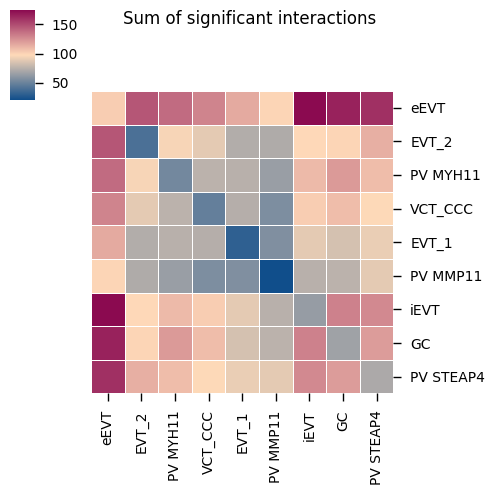

In [20]:
kpy.plot_cpdb_heatmap(pvals = cpdb_results['pvalues'],
                      degs_analysis = False,
                      figsize = (5, 5),
                      title = "Sum of significant interactions")

Here we are plotting the interactions between the PVs and the trophoblasts that are mediated by TGFB2 and CSF1R.

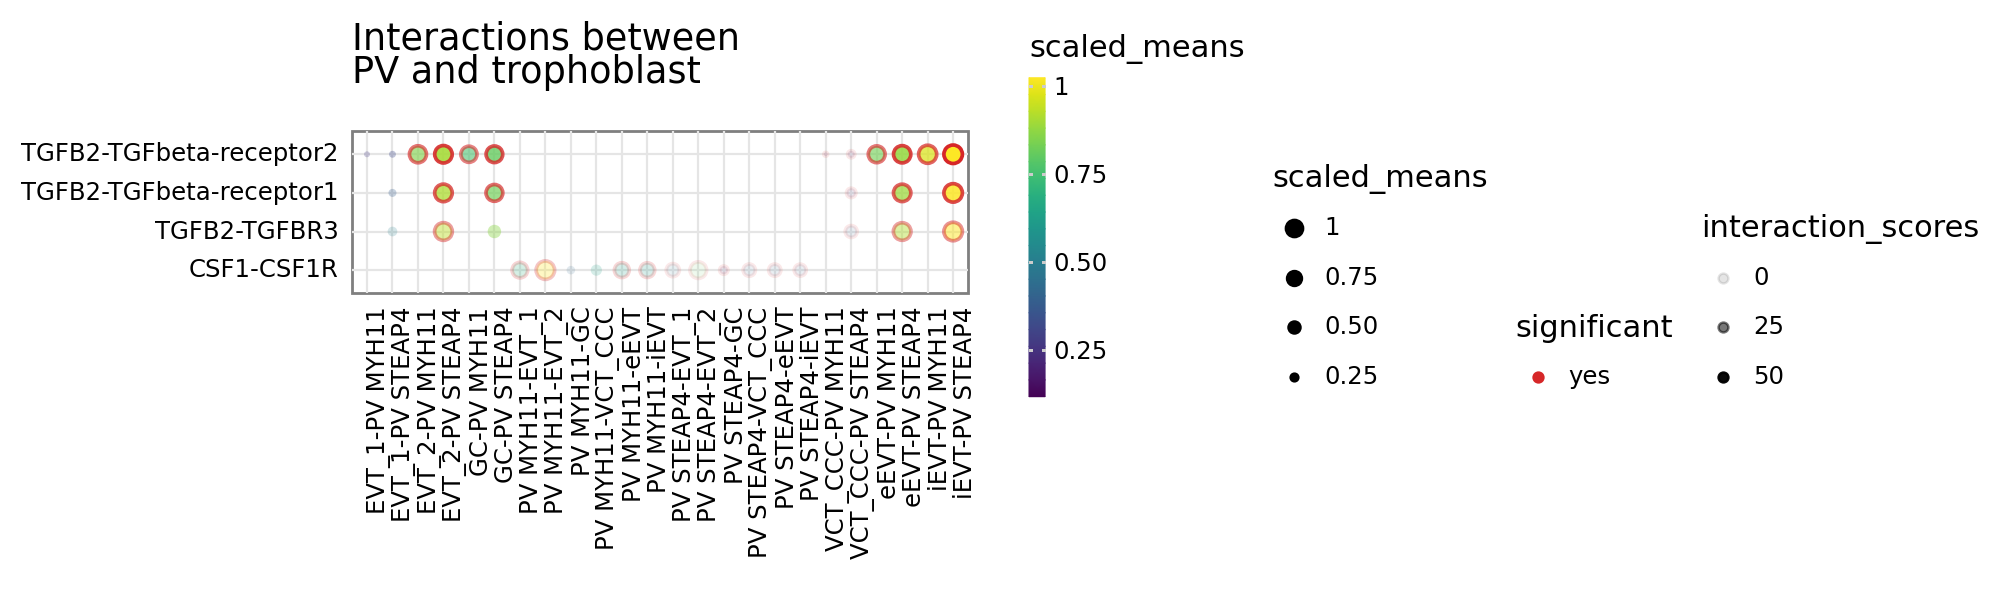

<Figure Size: (1000 x 300)>

In [21]:
kpy.plot_cpdb(
    adata = adata,
    cell_type1 = "PV MYH11|PV STEAP4|PV MMPP11",
    cell_type2 = "EVT_1|EVT_2|GC|iEVT|eEVT|VCT_CCC",
    means = cpdb_results['means'],
    pvals = cpdb_results['pvalues'],
    celltype_key = "cell_labels",
    genes = ["TGFB2", "CSF1R"],
    figsize = (10, 3),
    title = "Interactions between\nPV and trophoblast",
    max_size = 3,
    highlight_size = 0.75,
    degs_analysis = False,
    standard_scale = True,
    interaction_scores = cpdb_results['interaction_scores'],
    scale_alpha_by_interaction_scores = True
)

Interactions can also be plotted grouped by pathway.

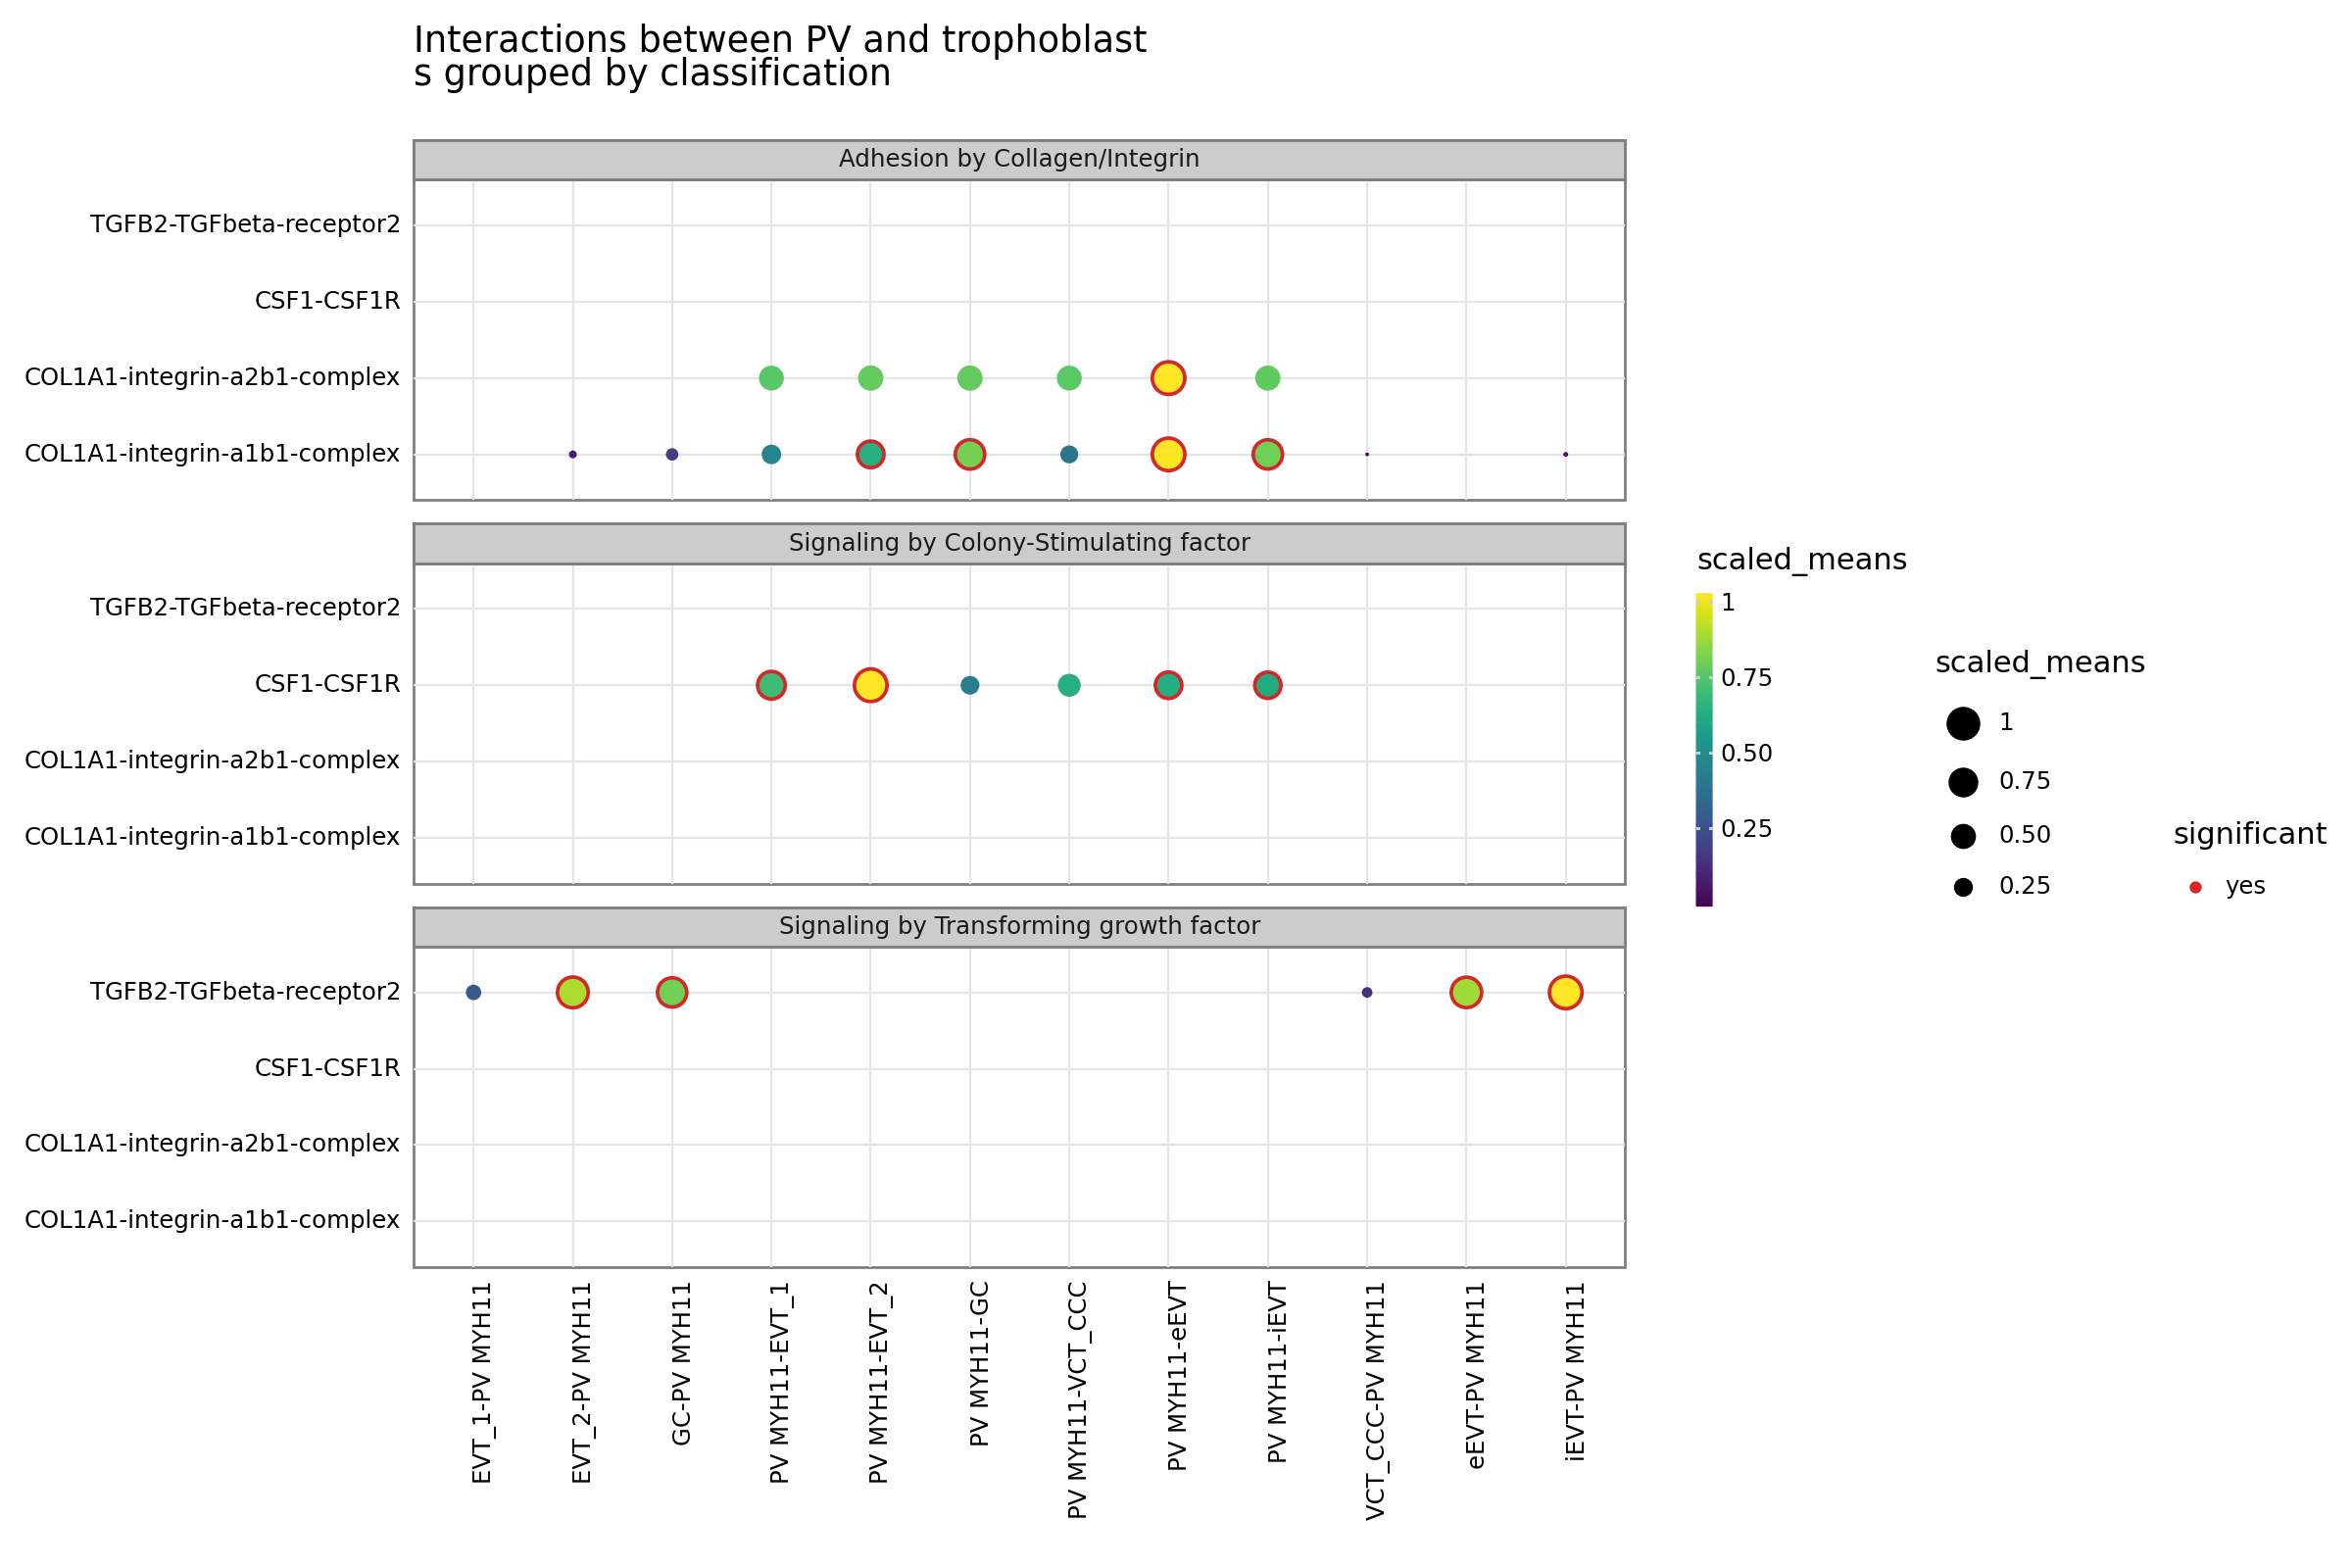

<Figure Size: (1200 x 800)>

In [22]:
from plotnine import facet_wrap

p = kpy.plot_cpdb(
    adata = adata,
    cell_type1 = "PV MYH11",
    cell_type2 = "EVT_1|EVT_2|GC|iEVT|eEVT|VCT_CCC",
    means = cpdb_results['means'],
    pvals = cpdb_results['pvalues'],
    celltype_key = "cell_labels",
    genes = ["TGFB2", "CSF1R", "COL1A1"],
    figsize = (12, 8),
    title = "Interactions between PV and trophoblast\ns grouped by classification",
    max_size = 6,
    highlight_size = 0.75,
    degs_analysis = False,
    standard_scale = True,
)
p + facet_wrap("~ classification", ncol = 1)

In [ ]:
from cellphonedb.src.core.methods import cpdb_statistical_analysis_method

cpdb_results = cpdb_statistical_analysis_method.call(
    cpdb_file_path = cpdb_file_path,                 
    meta_file_path = meta_file_path,                 
    counts_file_path = counts_file_path,             
    counts_data = 'hgnc_symbol',                     
    iterations = 1000,                               
    threshold = 0.1,                                 
    threads = 5,                                     
    debug_seed = 42,                                 
    result_precision = 3,                            
    pvalue = 0.05,                                   
    separator = '|',                                
    debug = False,                                   
    output_path = out_path,                          
    output_suffix = None                             
    
    active_tfs_file_path = active_tf_path,           # optional: defines cell types and their active TFs.
    microenvs_file_path = microenvs_file_path,       # optional (default: None): defines cells per microenvironment.
    score_interactions = True,                       # optional: whether to score interactions or not. 
    
    subsampling = False,                            
    subsampling_log = False,                         
    subsampling_num_pc = 100,                        
    subsampling_num_cells = 1000,                   
    e  (default: None).
    )